# What's a neural network

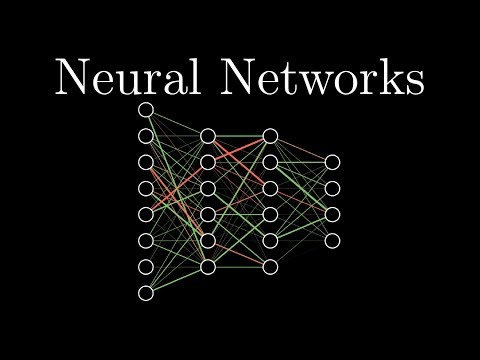

In [149]:
# This video explains very well what is a neural network,
# and also basically how it works via the hand-written digits recognition example.
from IPython.display import YouTubeVideo
YouTubeVideo('aircAruvnKk')

# The neural network we will build in this post

<img src="./hand_written_digits_recognition_nn_model.png">

We will again use the hand-written digits data to build a hand-written recognition neural network model in this post.

As you can see from above NN model graph, our NN has 3 layers:

  - An input layer: recall that each of the input hand-written digit holds a 20 by 20 pixels, which gives us 400 input layer units plus 1 always `+1` bias unit;
  
  - A hidden layer: which has 25 units (not counting the extra bias unit which always outputs `+1`);
  
  - An output layer: which has 10 output units (corresponding to the 10 digit classes);
  
That is:

$$
\begin{cases}
  a^{(1)}.shape &= (401, 1) \\
  \Theta^{(1)}.shape &= (25, 401) \\
  z^{(2)} = \Theta^{(1)} a^{(1)} = (25,401)@(401,1) &= (25, 1) \\
  \Theta^{(2)}.shape &= (10, 26) \\
  z^{(3)} = \Theta^{(2)} a^{(2)} = (10, 26)@(26, 1) &= (10, 1)
\end{cases}
$$

### Question: why the hidden layer has 25 units?

# Hand-written digits recognition with neural network

In [150]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sets the backend of matplotlib to the 'inline' backend.
#
# With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook,
# directly below the code cell that produced it.
# The resulting plots will then also be stored in the notebook document.
#
# More details: https://stackoverflow.com/questions/43027980/purpose-of-matplotlib-inline
%matplotlib inline

from scipy.io import loadmat

data = loadmat(os.getcwd() + '/hand_written_digits.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [151]:
X = data['X']
y = data['y']

X.shape, y.shape

((5000, 400), (5000, 1))

### Use [one-hot encoding](https://en.wikipedia.org/wiki/One-hot) to encode the classes labels

[One-hot encoding](https://en.wikipedia.org/wiki/One-hot) projects class label $K_i$ to a $K$-length vector, which its component at index $i$ is 1, and all others components are 0.

In [152]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)
y_onehot = onehot_encoder.fit_transform(y)
y_onehot.shape

(5000, 10)

In [153]:
y[0], y_onehot[0, :]

(array([10], dtype=uint8), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

In [154]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### `forward_propagate` just simulates the process that all inputs run through the neural network we defined, then returns the intermediate results and the final output.

In [155]:
def forward_propagate(X, theta1, theta2):
    a1 = np.insert(X, 0, values=np.ones(X.shape[0]), axis=1)
    z2 = a1 @ theta1.T
    
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(X.shape[0]), axis=1)
    z3 = a2 @ theta2.T
    
    h = sigmoid(z3)
    
    return a1, z2, a2, z3, h

### Define `cost` function (WITHOUT regularization item) to evaluate the loss of the network

$$
J(\theta) = -\frac{1}{n} \sum\limits_{i=1}^n \sum\limits_{k=1}^K \Big[ \
  y_k^{(i)}log\big( h_\theta(x^{(i)})_k \big) + \
  (1 - y_k^{(i)}) log\big( 1 - h_\theta(x^{(i)})_k \big) \
\Big]
$$

In [156]:
def cost(num_of_hidden_layer_units, num_of_labels, X, y, alpha):
    theta1 = (
        np.random.random(
            size=(num_of_hidden_layer_units, X.shape[1] + 1)
        ) - 0.5
    ) * 0.25
    
    theta2 = (
        np.random.random(
            size=(num_of_labels, num_of_hidden_layer_units + 1)
        ) - 0.5
    ) * 0.25
    
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    J = 0.
    for i in range(X.shape[0]):
        part0 = np.multiply(y[i,:], np.log(h[i,:]))
        part1 = np.multiply(1 - y[i,:], np.log(1 - h[i,:]))
        J += np.sum(part0 + part1)
        
    return -J/X.shape[0]

In [157]:
cost(25, 10, X, y_onehot, 1)

7.344220454216916

### Define `cost` function (WITH regularization item) to evaluate the loss of the network

$$
J(\theta) = -\frac{1}{n} \sum\limits_{i=1}^n \sum\limits_{k=1}^K \Big[ \
  y_k^{(i)}log\big( h_\theta(x^{(i)})_k \big) + \
  (1 - y_k^{(i)}) log\big( 1 - h_\theta(x^{(i)})_k \big) \
\Big] + \
  \frac{\alpha}{2n} \Big[ \
    \sum\limits_{j=1}^{25} \sum\limits_{k=1}^{400} (\Theta_{j,k}^{(1)})^2 + \
    \sum\limits_{j=1}^{10} \sum\limits_{k=1}^{25} (\Theta_{j,k}^{(2)})^2 \
\Big]
$$

As you can see, we don't regularize the bias unit.

In [158]:
def cost(num_of_hidden_layer_units, num_of_labels, X, y, alpha):
    theta1 = (
        np.random.random(
            size=(num_of_hidden_layer_units, X.shape[1] + 1)
        ) - 0.5
    ) * 0.25
    
    theta2 = (
        np.random.random(
            size=(num_of_labels, num_of_hidden_layer_units + 1)
        ) - 0.5
    ) * 0.25
    
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    J = 0.
    for i in range(X.shape[0]):
        part0 = np.multiply(y[i,:], np.log(h[i,:]))
        part1 = np.multiply(1 - y[i,:], np.log(1 - h[i,:]))
        J += np.sum(part0 + part1)
        
    regularization_item = float(alpha) / (2 * X.shape[0]) * (
        np.sum(
            np.power(theta1[:,1:], 2)
        ) +
        np.sum(
            np.power(theta2[:,1:], 2)
        )
    )
        
    return -J/X.shape[0] + regularization_item

In [159]:
cost(25, 10, X, y_onehot, 1)

7.4294433121188534

### Computes the gradient of the sigmoid function

In [160]:
def sigmoid_gradient(x):
    return np.multiply(sigmoid(x), (1 - sigmoid(x)))

### Implement backpropagation algorithm (WITH cost regularization item and gradient regularization item)

- Backpropagation computes the parameter updates that will reduce the error of the network on the training data.


- Combine the [Chain rule](https://en.wikipedia.org/wiki/Chain_rule) and the below two graphs should be good enough to explain what is and what does backpropagation algorithm do.

  Lets take calculating the derivative of $e=(a+b)*(b+1)$ as example, and lets introduce in intermediate variables $c=a+b$ and $d=b+1$:
    
  <img src="./bp_0.png">

  For calculating the $d_e|_{a=2,b=1}$, with the [Chain rule](https://en.wikipedia.org/wiki/Chain_rule) we know:
  $$
  \begin{align*}
    d_e|_{a=2,b=1} &= \frac{\partial e}{\partial a} + \frac{\partial e}{\partial b} \\
    &= \frac{\partial e}{\partial c} \cdot \frac{\partial c}{\partial a} + \
    \frac{\partial e}{\partial c} \cdot \frac{\partial c}{\partial b} + \
    \frac{\partial e}{\partial d} \cdot \frac{\partial d}{\partial b}
  \end{align*}
  $$
 
  If we visualize the above chain rules in a tree, we get:
    
  <img src="./bp_1.png">
    
  We found that actually:
    
  1. The value of $\frac{\partial e}{\partial a}$ is the product of all the derivatives on the path from node $a$ to node $e$;
      
  2. The value of $\frac{\partial e}{\partial b}$ is the sum of the product of all the derivatives on the two different paths respectively from node $b$ to node $e$;


  That means: to upper node $p$ and lower node $q$, for calculating $\frac{\partial p}{\partial q}$ we need to find out all the paths from node $q$ to node $p$, then to each path we calculate the product of all the derivatives on that path, and then sum all the products from all the different paths!

  But maybe you already noticed: we visited certain paths multiple times, for example: path 'a-c-e' and 'b-c-e' both visited path 'c-e', this duplicated traversal cost to a huge neural network is significant!


- And here is also where the backpropagation algorithm comes in: just like indicated in its name (back), it looks up the paths from the root node to the leaf nodes, and traverse each path eactly once, how it achieves this:
    
  1. It starts from root node with initial value `1`, and processes the others nodes by layer from top to bottom;
    
  2. To each node (lets say $p$), calculate the derivative of $p$ to each of its direct children (lets say $q$), that is: $\frac{\partial p}{\partial q}$, then store the product of the value that accumulated on node $p$ (for root node it is our initial value `1`) and the just calculated $\frac{\partial p}{\partial q}$ on node $q$;
    
  3. After finished one layer, sum all the stored values on each node respectively, and store as its accumulated value;
    
  4. Repeat step '2' and '3' until finish all the nodes, the value lastly accumulated on the leaf node (lets say $q$) is the derivative of the root node (lets say $p$) to this leaf node, that is: $\frac{\partial p}{\partial q}$!
    
  More clearly, still with above example, demonstrate the process with below graph:

  <img src="bp_demo.svg">


- The computations required for backpropagation are a superset of those required in the cost function, so what we will do actually is extending the cost function to perform the backpropagation as well, and then return both the cost and the gradients.


- And since we will use our `backprop` function with the `scipy.optimize.minimize` function, which means the `backprop` will be called upon each epoch of the training, so we cannot do the `theta1` and `theta2` random generation like our above `cost` function, but pass in through the `params`.

In [161]:
def backprop(params, num_of_hidden_layer_units, num_of_labels, X, y, alpha):
    theta1 = np.reshape(
        params[:num_of_hidden_layer_units * (X.shape[1] + 1)],
        (num_of_hidden_layer_units, X.shape[1] + 1)
    )
    
    theta2 = np.reshape(
        params[num_of_hidden_layer_units * (X.shape[1] + 1):],
        (num_of_labels, num_of_hidden_layer_units + 1)
    )
    
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # Initializations.
    J = 0.
    delta1 = np.zeros(theta1.shape) # (25, 401)
    delta2 = np.zeros(theta2.shape) # (10, 26)
    
    # Compute the cost.
    for i in range(X.shape[0]):
        part0 = np.multiply(y[i,:], np.log(h[i,:]))
        part1 = np.multiply(1 - y[i,:], np.log(1 - h[i,:]))
        J += np.sum(part0 + part1)
        
    J = -J/X.shape[0]
    
    # Add the regularization item to cost.
    cost_regularization_item = float(alpha) / (2 * X.shape[0]) * (
        np.sum(
            np.power(theta1[:,1:], 2)
        ) +
        np.sum(
            np.power(theta2[:,1:], 2)
        )
    )
    J += cost_regularization_item
    
    # Perform backpropagation.
    for t in range(X.shape[0]):
        a1t = a1[[t],:] # (1, 401)
        z2t = z2[[t],:] # (1, 25)
        a2t = a2[[t],:] # (1, 26)
        ht = h[[t],:]   # (1, 10)
        yt = y[[t],:]   # (1, 10)
        
        d3t = ht - yt # (1, 10)
        
        z2t = np.insert(z2t, 0, values=np.ones(z2t.shape[0]), axis=1) # (1, 26)
        d2t = np.multiply(d3t @ theta2, sigmoid_gradient(z2t)) # (1, 26)
        
        delta1 += d2t[:,1:].T @ a1t
        delta2 += d3t.T @ a2t
        
    delta1 /= X.shape[0]
    delta2 /= X.shape[0]
    
    # Add the regularization item to the gradient.
    # Note:
    #   We never regularize the bias item.
    delta1[:,1:] += theta1[:,1:] * alpha / X.shape[0]
    delta2[:,1:] += theta2[:,1:] * alpha / X.shape[0]
    
    # Unravel the gradient matrices into a single array.
    # Note:
    #   The first parameter of `np.concatenate` needs to be a tuple.
    grad = np.concatenate(
        (np.ravel(delta1), np.ravel(delta2))
    )
    
    return J, grad

In [162]:
num_of_labels = 10
num_of_hidden_layer_units = 25

params = (
  np.random.random(
    size=25 * (X.shape[1] + 1) + num_of_labels * (num_of_hidden_layer_units + 1)
  ) - 0.5
) * 0.25

J, grad = backprop(params, num_of_hidden_layer_units, num_of_labels, X, y_onehot, 1)
J, grad.shape

(7.028314154117359, (10285,))

### Finally we are ready to train our network

We put a bound on the number of iterations since the objective function is not likely to completely converge. As you can see the total cost has dropped below to around 0.3 though, so that's a good indicator that the algorithm is working.

In [163]:
from scipy.optimize import minimize

# Minimize the objective function.
fmin = minimize(
    fun=backprop, x0=params, args=(num_of_hidden_layer_units, num_of_labels, X, y_onehot, 1), 
    method='TNC', jac=True, options={'maxiter': 250}
)

fmin

     fun: 0.33308470063511797
     jac: array([-1.25542596e-04, -1.98582370e-06,  1.30375863e-06, ...,
        2.57560223e-04,  2.46215958e-04,  4.36715673e-04])
 message: 'Max. number of function evaluations reached'
    nfev: 250
     nit: 21
  status: 3
 success: False
       x: array([-1.25399465, -0.00992912,  0.00651879, ..., -0.60387196,
       -1.44008762,  0.86657429])

### Let's use the parameters it found and forward-propagate them through the network to get some predictions, and evaluate the overall accuracy of our network

In [164]:
theta1 = np.reshape(
    fmin.x[:num_of_hidden_layer_units * (X.shape[1] + 1)],
    (num_of_hidden_layer_units, X.shape[1] + 1)
)

theta2 = np.reshape(
    fmin.x[num_of_hidden_layer_units * (X.shape[1] + 1):],
    (num_of_labels, num_of_hidden_layer_units + 1)
)

a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)

y_pred = np.array(np.argmax(h, axis=1) + 1)

correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('Total accuracy: {0:.2f}%'.format(accuracy * 100))

Total accuracy: 99.44%


# References

- [Programming Exercise 4: Neural Networks Learning](https://github.com/jdwittenauer/ipython-notebooks/blob/master/exercises/ML/ex4.pdf)

- [机器学习练习（五）—— 神经网络](https://blog.csdn.net/and_w/article/details/53612320)

- [One-hot](https://en.wikipedia.org/wiki/One-hot)

- [如何直观地解释 backpropagation 算法？](https://www.zhihu.com/question/27239198/answer/89853077)

- [Calculus on Computational Graphs: Backpropagation](http://colah.github.io/posts/2015-08-Backprop/)

- [How the backpropagation algorithm works](http://neuralnetworksanddeeplearning.com/chap2.html)

- [Chain rule](https://en.wikipedia.org/wiki/Chain_rule)